# Numerical grid scale noise in vertical velocities

__author__ : Aurélie Albert & Julien Le Sommer (MEOM)

__context__ : 22-GLO-HR project : Lot 1 - Ocean Modelling

__date__ : 11 December 2017

__purpose__ : Metric for the intensity of the numerical grid scale noise in vertical velocities

__practical steps__ :

  * We look at vertical velocities along a cross-section of the Labrador Sea (56°Wx53.5°N => 48°w-60.5°N)
  * step 1. : The cross-section is defined and vertical velocities are plotted for an average 5-days in early September 2013.
  * step 2. : A smoothing is performed for each vertical profile of the cross-section using a hanning filter with a window of 3 grid points.
  * step 3. : We deduce a metric from the unfiltered part of the signal by taking the absolute value of it.
  
__libraries useful for this study __ : 

Installation not needed

 * Pypago : https://sourcesup.renater.fr/pago/pypago.html
 
__licence__ : This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">Creative Commons Attribution 4.0 International License</a>.

## 0. Importing modules

In [4]:
# import modules
import numpy as np
import numpy.ma as ma
import xarray as xr

import matplotlib
import matplotlib.cm as cm
import pylab as plt

from mpl_toolkits.basemap import Basemap
from mpl_toolkits.basemap import pyproj

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
%autosave 60

Autosaving every 60 seconds


In [5]:
#data and grid
gridname='/media/extra/DATA/NACHOS12.L75/NACHOS12.L75-I/NACHOS12.L75-MAA13_mesh_mask.nc'
dgrid=xr.open_dataset(gridname)
navlon=dgrid['nav_lon']
navlat=dgrid['nav_lat']

wname='/media/extra/DATA/NACHOS12.L75/NACHOS12.L75-MAA13-S/NACHOS12.L75-MAA13_y2013m09d08.5d_gridW.nc'
dw=xr.open_dataset(wname)
w=dw['vovecrtz']
depthw=dw['depthw']

## 1 - Defining the Labrador cross-section

Block codes taken from pypago routines

In [6]:
def section_from_debut_fin_points(lon_ar7w_debut,lat_ar7w_debut,lon_ar7w_fin,lat_ar7w_fin,navlon,navlat,var):
    
    ee = pyproj.Geod(ellps='GRS80') # ellipsoid used for distance calculation
    
    def distance(lat1,lon1,lat2,lon2,geoid):
        az12,az21,dist = geoid.inv(lon1,lat1,lon2,lat2)
        return dist

    def loclatlon(navlon,navlat,lon,lat):
        ind_debut=np.where((navlon>lon-0.1)&(navlon<lon+0.1)&(navlat>lat-0.1)&(navlat<lat+0.1))
        dis=np.empty(len(ind_debut[0]))
        for ii in range(0,len(ind_debut[0])):
            dis[ii]=np.abs(distance(lat,lon,navlat[ind_debut[0][ii],ind_debut[1][ii]],navlon[ind_debut[0][ii],ind_debut[1][ii]],ee))
        ind=np.argmin(dis)
        i_debut=ind_debut[0][ind]
        j_debut=ind_debut[1][ind]
    
        return i_debut,j_debut
 
    def secfromdebuttofin(i_debut,j_debut,i_fin,j_fin):
        off=1
        fromi=np.atleast_1d(i_debut)+off
        fromj=np.atleast_1d(j_debut)+off
        toi=np.atleast_1d(i_fin)+off
        toj=np.atleast_1d(j_fin)+off

        veci=fromi
        vecj=fromj

        a=(toj-fromj)/((toi-fromi).astype(np.float))
        b=toj-toi*a

        while not((veci[-1]==toi) & (vecj[-1]==toj)):
            newi=veci[-1]+np.sign(toi-fromi)
            newj=vecj[-1]+np.sign(toj-fromj)
            y=a*newi+b
            x=(newj-b)/(a.astype(np.float))

            if ((np.abs(x-veci[-1]))>=(np.abs(y-vecj[-1]))):
                veci=np.append(veci,newi)
                vecj=np.append(vecj,vecj[-1])
            else:
                veci=np.append(veci,veci[-1])
                vecj=np.append(vecj,newj)

        veci=veci.astype(np.int)-off
        vecj=vecj.astype(np.int)-off

        dis=np.empty(len(veci))
        for ii in range(0,len(veci)):
            dis[ii]=np.abs(distance(navlat[veci[0],vecj[0]],navlon[veci[0],vecj[0]],navlat[veci[ii],vecj[ii]],navlon[veci[ii],vecj[ii]],ee))
    
        return veci,vecj,dis
            
    i_debut,j_debut=loclatlon(navlon,navlat,lon_ar7w_debut,lat_ar7w_debut)
    i_fin,j_fin=loclatlon(navlon,navlat,lon_ar7w_fin,lat_ar7w_fin)

    veci,vecj,dis=secfromdebuttofin(i_debut,j_debut,i_fin,j_fin)

    if np.ndim(var) == 4:
        [nt,nk,nj,ni]=var.shape
        var_sec=np.empty([nt,nk,len(veci)])
        for ii in range(0,len(veci)):
            var_sec[:,:,ii]=var[:,:,veci[ii],vecj[ii]]
    if np.ndim(var) == 3:
        [nt,nj,ni]=var.shape
        var_sec=np.empty([nt,len(veci)])
        for ii in range(0,len(veci)):
            var_sec[:,ii]=var[:,veci[ii],vecj[ii]]
    
    return veci,vecj,dis,var_sec

In [7]:
#Labrador section beginning and end point

lon_ar7w_debut=np.array(-56).astype(np.float)
lon_ar7w_fin=np.array(-48).astype(np.float)

lat_ar7w_debut=np.array(53.5).astype(np.float)
lat_ar7w_fin=np.array(60.5).astype(np.float)

veci,vecj,dis,wlabrador=section_from_debut_fin_points(lon_ar7w_debut,lat_ar7w_debut,lon_ar7w_fin,lat_ar7w_fin,navlon,navlat,w)
wlabrador_smooth=np.ones(wlabrador.shape)


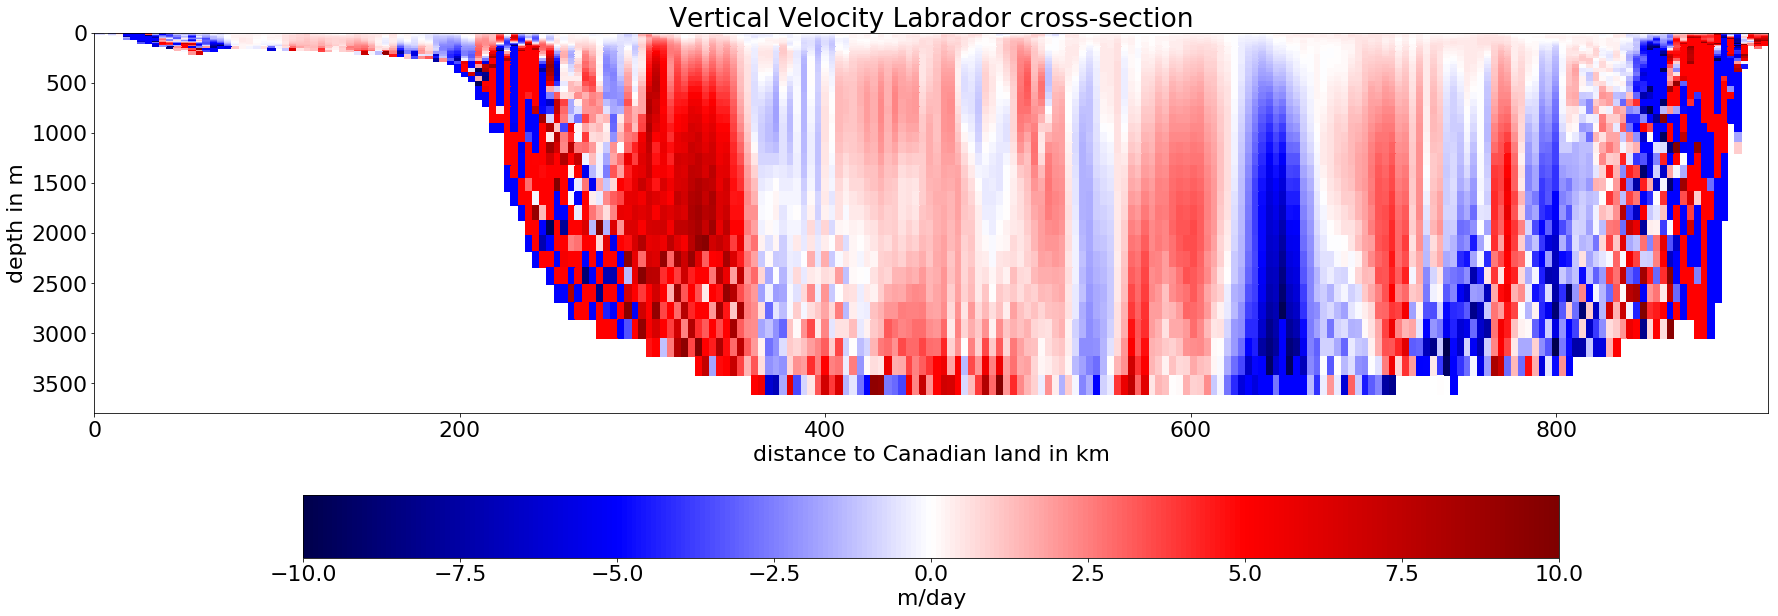

In [8]:
matplotlib.rcParams.update({'font.size': 22})
ma_wlabrador = np.ma.array (wlabrador, mask=np.isnan(wlabrador))

plt.figure(figsize=(30,10))

ax=plt.subplot(1,1,1)
cmap2 = plt.cm.seismic
cmap2.set_under('b')
cmap2.set_over('r')
pcolor=plt.pcolor(1e-3*dis,depthw,86400*ma_wlabrador[0,:,:],cmap=cmap2,vmin=-10,vmax=10)
plt.gca().invert_yaxis()
cbar = plt.colorbar(pcolor,orientation='horizontal',shrink=0.75,label='m/day')
ax.set_ylim(3800,0)
plt.xlabel('distance to Canadian land in km')
plt.ylabel('depth in m')
plt.title('Vertical Velocity Labrador cross-section');


## 2 - Smoothing of vertical profiles along the cross-section

In [9]:
# Hanning filter with window size of 3 grid points
for ii in range(len(veci)):
    profil=wlabrador[0,:,ii]
    window_len=3
    s=np.r_[profil[window_len-1:0:-1],profil,profil[-2:-window_len-1:-1]]
    whanning=np.hanning(window_len)
    yhanning=np.convolve(whanning/whanning.sum(),s,mode='valid')
    wlabrador_smooth[0,:,ii]=yhanning[0:75]


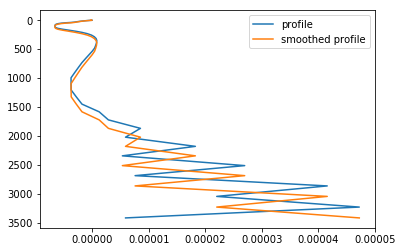

In [10]:
# Results for one profile
matplotlib.rcParams.update({'font.size': 10})
plt.plot(wlabrador[0,:,100],depthw,label='profile')
plt.plot(wlabrador_smooth[0,:,100],depthw,label='smoothed profile')
plt.legend()
plt.gca().invert_yaxis()

## 3 - Metric for numerical vertical grid scale noise

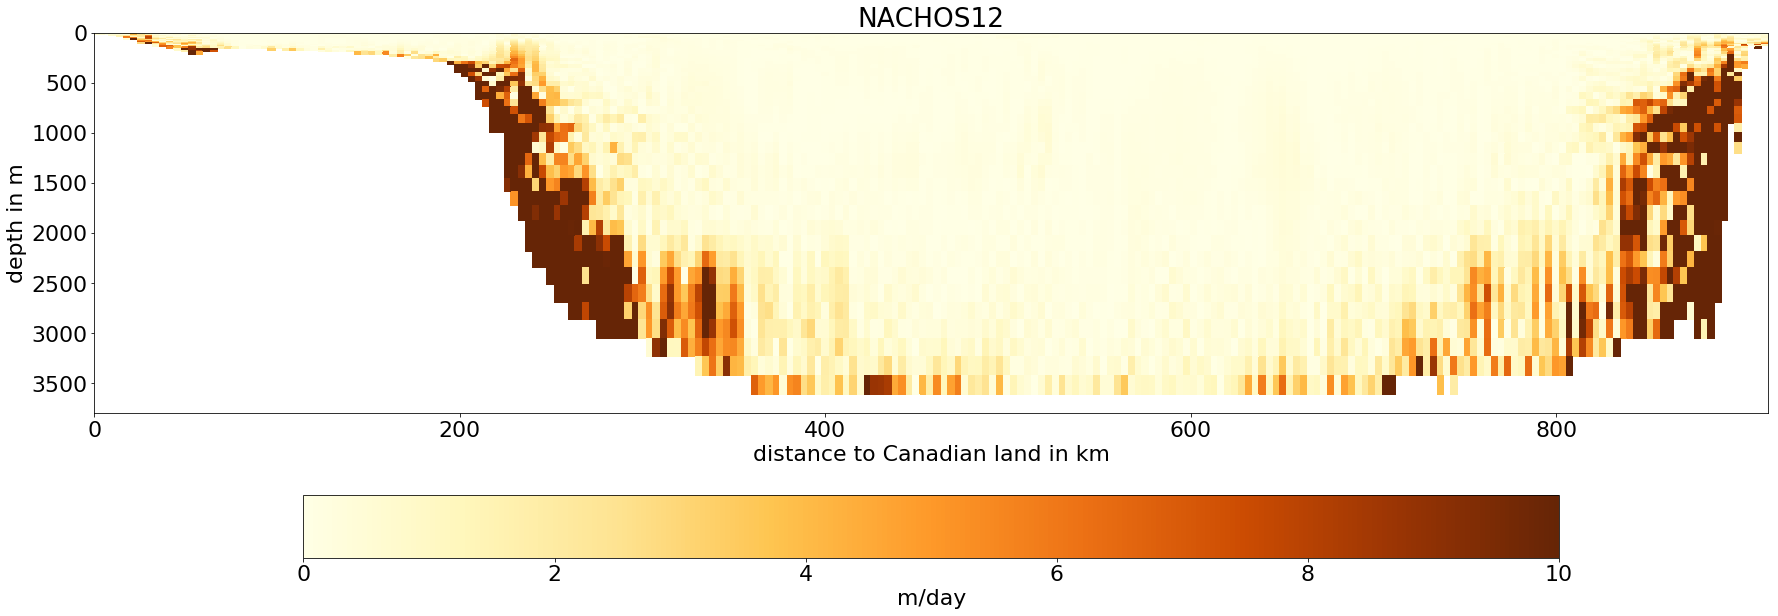

In [11]:
ma_wlabrador_smooth = np.ma.array (wlabrador_smooth, mask=np.isnan(wlabrador_smooth))
matplotlib.rcParams.update({'font.size': 22})

plt.figure(figsize=(30,10))


ax=plt.subplot(1,1,1)
pcolor=plt.pcolor(1e-3*dis,depthw,86400*np.abs(ma_wlabrador[0,:,:]-ma_wlabrador_smooth[0,:,:]),cmap='YlOrBr',vmin=0,vmax=10)
plt.gca().invert_yaxis()
cbar = plt.colorbar(pcolor,orientation='horizontal',shrink=0.75,label='m/day')
ax.set_ylim(3800,0)
#ax.set_xlim(100,900)
plt.xlabel('distance to Canadian land in km')
plt.ylabel('depth in m')
plt.title('NACHOS12')

plt.savefig('NACHOS12_w_vert_grid_noise_labrador_08092013.png')

## Appendix : same diagnostic is applied on the Ovide section

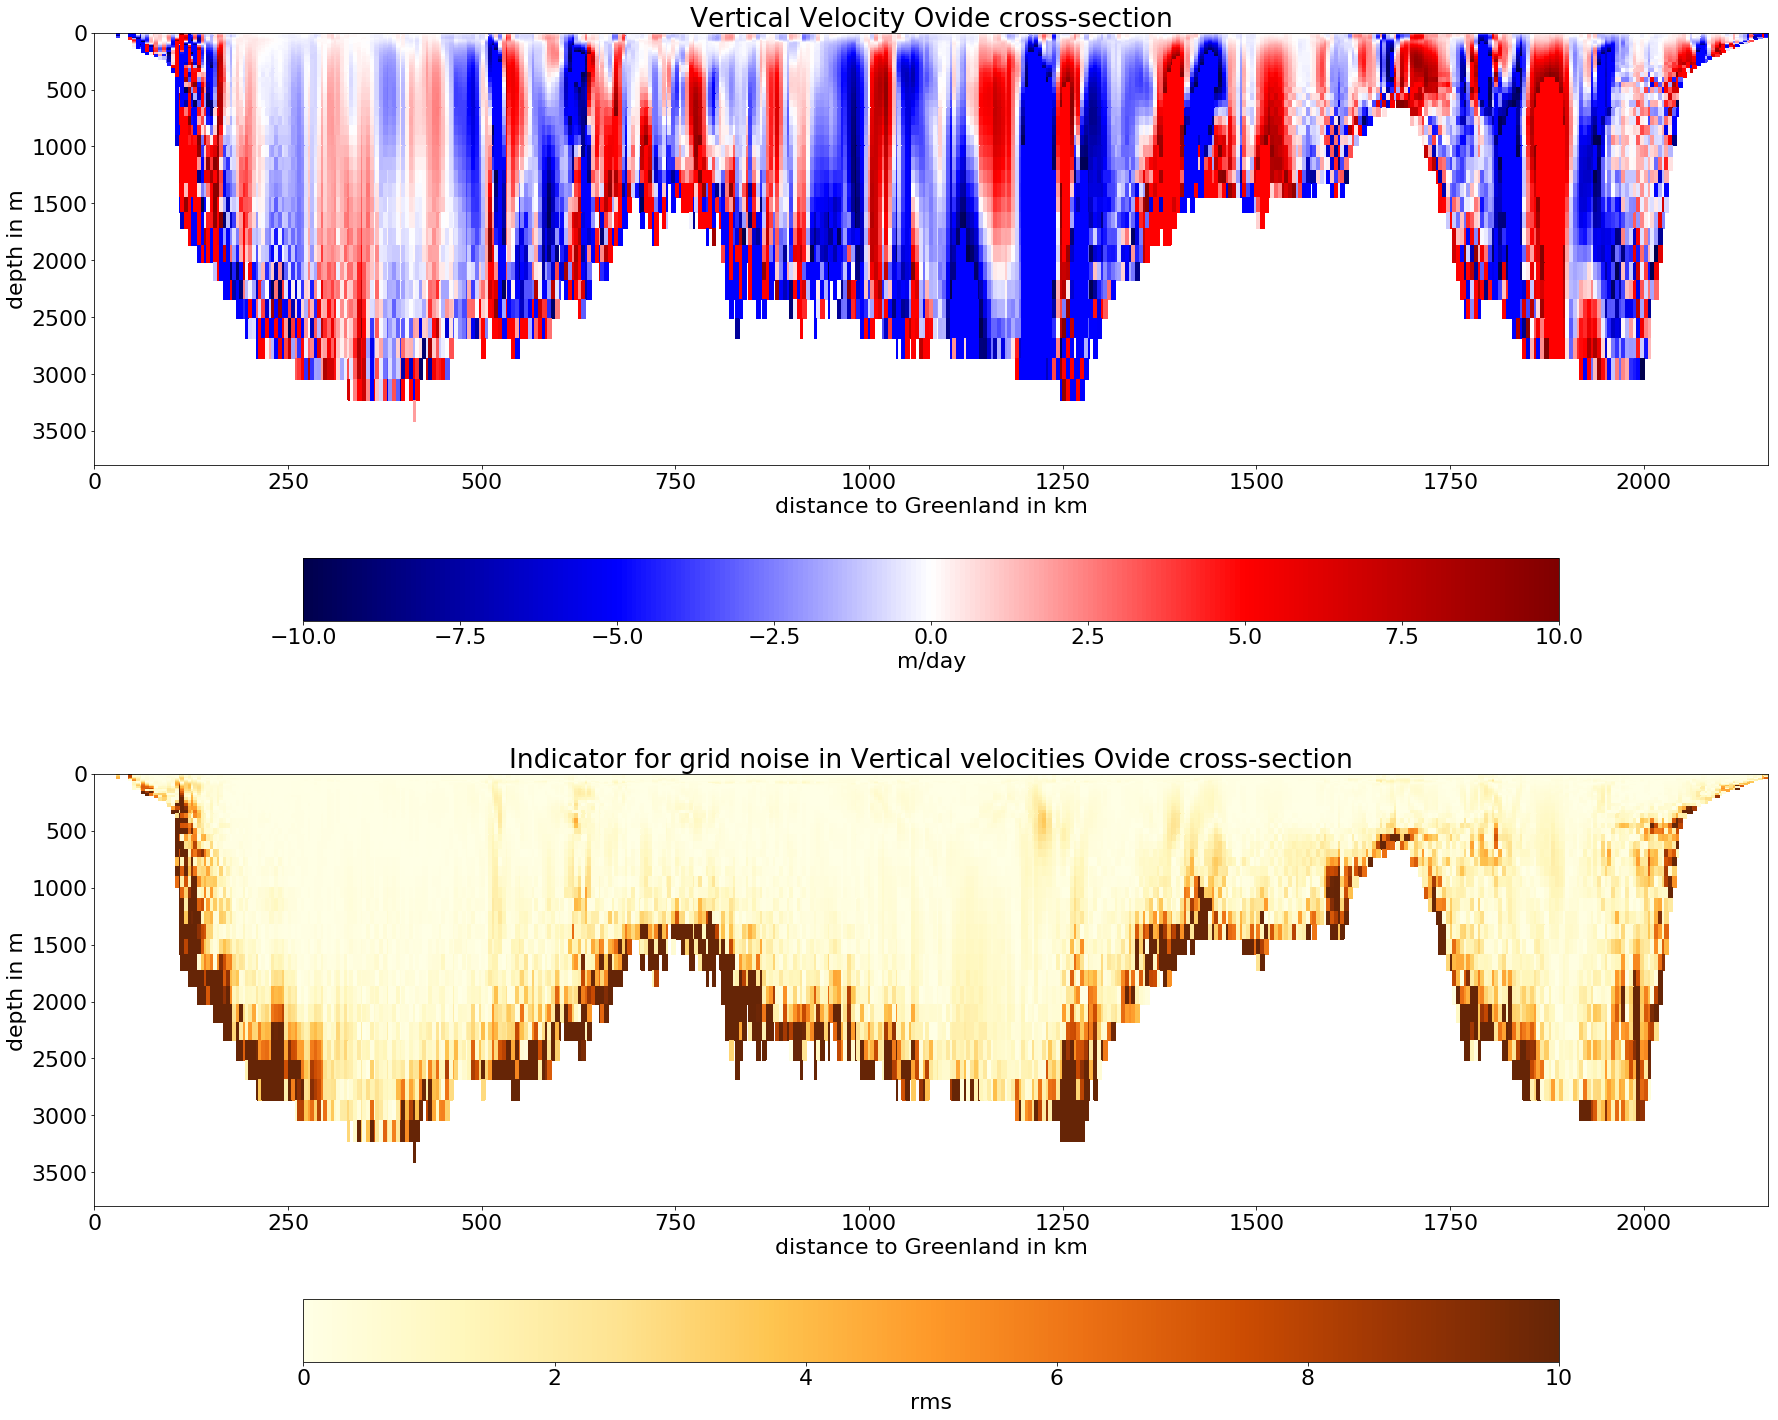

In [13]:
#Ovide section beginning and end point

lon_ovide_debut=np.array(-44).astype(np.float)
lon_ovide_fin=np.array(-10).astype(np.float)

lat_ovide_debut=np.array(60).astype(np.float)
lat_ovide_fin=np.array(53.75).astype(np.float)

veci,vecj,dis,wovide=section_from_debut_fin_points(lon_ovide_debut,lat_ovide_debut,lon_ovide_fin,lat_ovide_fin,navlon,navlat,w)
wovide_smooth=np.ones(wovide.shape)

for ii in range(len(veci)):
    profil=wovide[0,:,ii]
    window_len=3
    s=np.r_[profil[window_len-1:0:-1],profil,profil[-2:-window_len-1:-1]]
    whanning=np.hanning(window_len)
    yhanning=np.convolve(whanning/whanning.sum(),s,mode='valid')
    wovide_smooth[0,:,ii]=yhanning[0:75]

ma_wovide = np.ma.array (wovide, mask=np.isnan(wovide))
ma_wovide_smooth = np.ma.array (wovide_smooth, mask=np.isnan(wovide_smooth))

matplotlib.rcParams.update({'font.size': 22})

plt.figure(figsize=(30,25))

ax=plt.subplot(2,1,1)
cmap2 = plt.cm.seismic
cmap2.set_under('b')
cmap2.set_over('r')
pcolor=plt.pcolor(1e-3*dis,depthw,86400*ma_wovide[0,:,:],cmap=cmap2,vmin=-10,vmax=10)
plt.gca().invert_yaxis()
cbar = plt.colorbar(pcolor,orientation='horizontal',shrink=0.75,label='m/day')
ax.set_ylim(3800,0)
#ax.set_xlim(100,900)
plt.xlabel('distance to Greenland in km')
plt.ylabel('depth in m')
plt.title('Vertical Velocity Ovide cross-section');

ax=plt.subplot(2,1,2)
cmap2 = plt.cm.seismic
cmap2.set_under('b')
cmap2.set_over('r')
pcolor=plt.pcolor(1e-3*dis,depthw,86400*np.abs(ma_wovide[0,:,:]-ma_wovide_smooth[0,:,:]),cmap='YlOrBr',vmin=0,vmax=10)
plt.gca().invert_yaxis()
cbar = plt.colorbar(pcolor,orientation='horizontal',shrink=0.75,label='rms')
ax.set_ylim(3800,0)
#ax.set_xlim(100,900)
plt.xlabel('distance to Greenland in km')
plt.ylabel('depth in m')
plt.title('Indicator for grid noise in Vertical velocities Ovide cross-section');